In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Getting the data

In [2]:
# Let's define each of these directories:
# Directory with our training horse pictures
train_horse_dir = os.path.join('tmp/train/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('tmp/train/humans')

In [ ]:
# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation/humans')

In [3]:
# Now, let's see what the filenames look like in the horses and humans training directories:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse43-5.png', 'horse06-5.png', 'horse20-6.png', 'horse04-7.png', 'horse41-7.png', 'horse22-4.png', 'horse19-2.png', 'horse24-2.png', 'horse37-8.png', 'horse02-1.png']
['human17-22.png', 'human10-17.png', 'human10-03.png', 'human07-27.png', 'human09-22.png', 'human05-22.png', 'human02-03.png', 'human02-17.png', 'human15-27.png', 'human12-12.png']


In [ ]:
validation_horse_hames = os.listdir(validation_horse_dir)
print(validation_horse_hames[:10])

validation_human_names = os.listdir(validation_human_dir)
print(validation_human_names[:10])

In [4]:
# Let's find out the total number of horse and human images in the directories:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


In [ ]:
print('total validation horse images:', len(os.listdir(validation_horse_dir)))
print('total validation human images:', len(os.listdir(validation_human_dir)))

# Visualizing the data

In [5]:
%matplotlib inline

import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

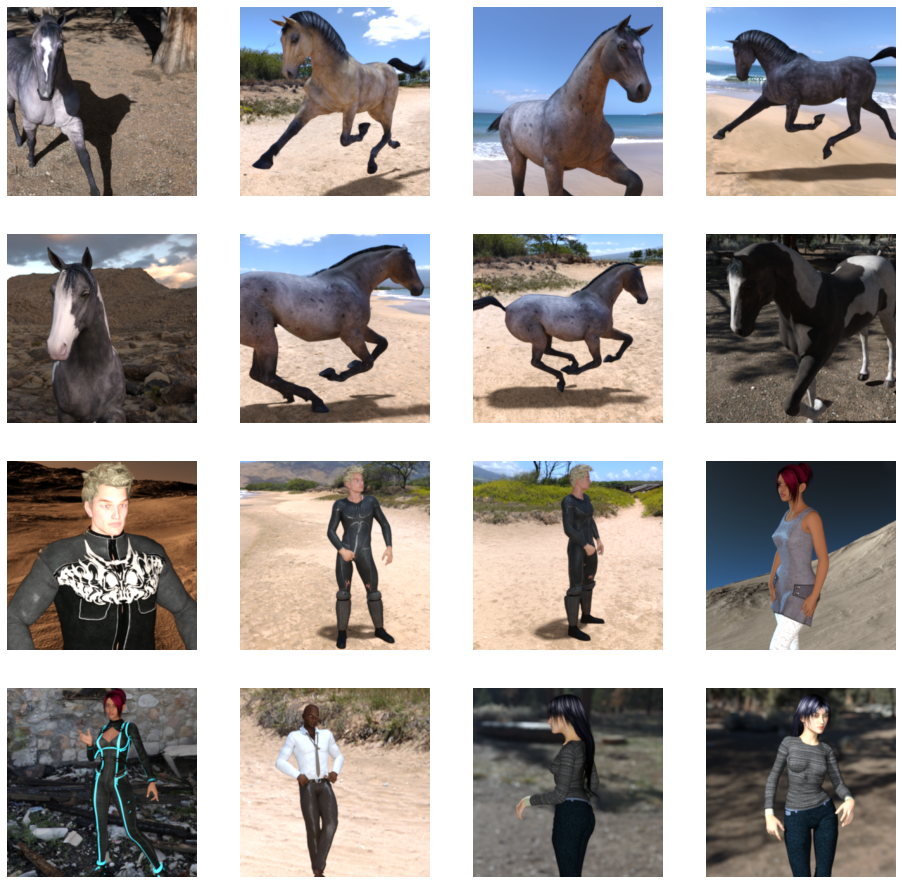

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Data preprocessing

##### Let's set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary). Data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range). In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit, evaluate_generator, and predict_generator.

In [7]:
# Images with different sizes and no labels
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255) # we call the flow from directory method on it to get to load images from that directory

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'tmp/train/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.


In [8]:
# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale=1/255) # we call the flow from directory method on it to get to load images from that directory

# Flow training images in batches of 128 using train_datagen generator
validation_generator = train_datagen.flow_from_directory(
        'tmp/validation/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 256 images belonging to 2 classes.


# Model

##### We add convolutional layers and flatten the final result to feed into the densely connected layers. Note that because we are facing a two-class classification problem, i.e. a binary classification problem, we will end our network with a sigmoid activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0). As well, we resize their images to be 300 by 300 as they were loaded, but they're also color images. So there are three bytes per pixel. One byte for the red, one for green, and one for the blue channel, and that's a common 24-bit color pattern. 

In [9]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

##### Important: We can resize our images to a smaller size to save time computing

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

###### The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

# Building and training the model

In [11]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

##### We will train our model with the binary_crossentropy loss, because it's a binary classification problem and our final activation is a sigmoid.  We will use the rmsprop optimizer with a learning rate of 0.001. During training, we will want to monitor classification accuracy.

In [12]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      validation_data=validation_generator,
      validation_steps=8,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 101s 13s/step - loss: 0.7291 - accuracy: 0.5617 - val_loss: 0.6495 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 106s 13s/step - loss: 0.9198 - accuracy: 0.6263 - val_loss: 0.6338 - val_accuracy: 0.8359
Epoch 3/15
8/8 [==============================] - 105s 13s/step - loss: 0.6617 - accuracy: 0.6719 - val_loss: 0.5663 - val_accuracy: 0.7070
Epoch 4/15
8/8 [==============================] - 121s 15s/step - loss: 0.5668 - accuracy: 0.7831 - val_loss: 0.4831 - val_accuracy: 0.7969
Epoch 5/15
8/8 [==============================] - 124s 15s/step - loss: 0.3190 - accuracy: 0.9043 - val_loss: 3.0571 - val_accuracy: 0.6367
Epoch 6/15
8/8 [==============================] - 122s 15s/step - loss: 0.2892 - accuracy: 0.9155 - val_loss: 0.5652 - val_accuracy: 0.9023
Epoch 7/15
8/8 [==============================] - 128s 16s/step - loss: 0.2405 - accuracy: 0.9210 - val_loss: 1.3981 - val_accuracy: 0.7969
Epoch 8/15
8/8 [====

##### The first parameter is the training generator that we set up earlier. This streams the images from the training directory. Remember the batch size we used when we created it, it was 128. There are 1,024 images in the training directory, so we're loading them in 128 at a time. So in order to load them all, we need to do 8 batches. So we set the steps_per_epoch to cover that. And we set the number of epochs to train for 15 epochs in this case. And now we specify the validation set that comes from the validation_generator that we also created earlier. It had 256 images, and we wanted to handle them in batches of 32, so we will do 8 steps.And the verbose parameter specifies how much to display while training is going on. With verbose set to 2, we'll get a little less animation hiding the epoch progress. 

# Visualizing Intermediate Representations

##### To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet. Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

<ipython-input-14-d5bfb57b081c>:43: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


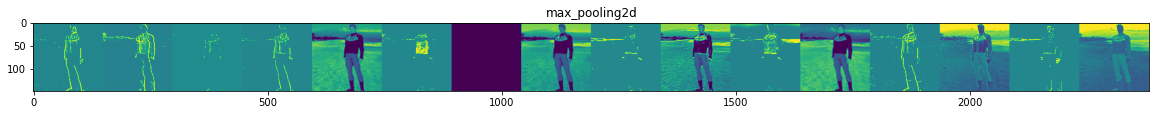

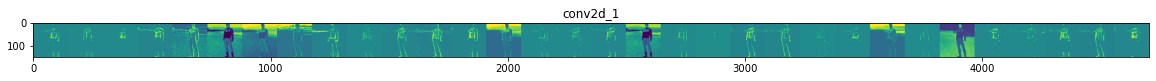

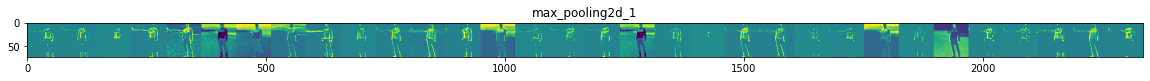

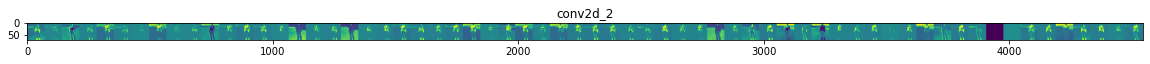

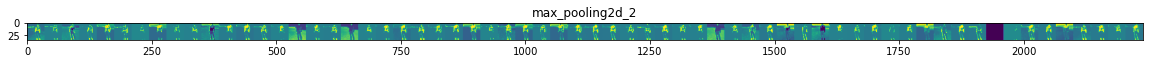

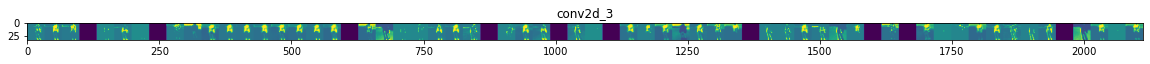

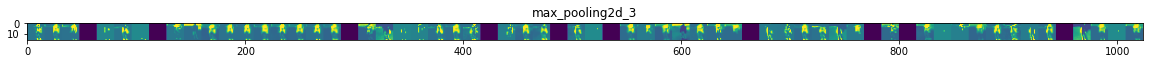

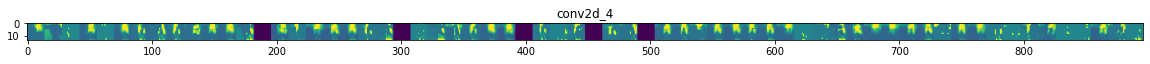

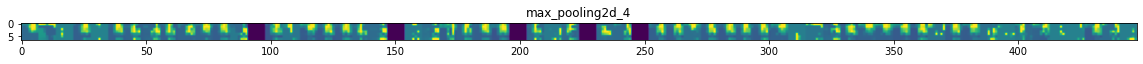

In [14]:
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

##### As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.